### "Шапка" с названием проекта

В этой ячейке вы найдете оглавление и ключевые этапы работы, которые помогут вам ориентироваться в процессе выполнения проекта. Проект разделен на пять основных этапов, четыре из которых (этапы 2, 3, 4 и 5) вам предлагается выполнить в этом Jupyter Notebook:

- Подготовка среды MLflow - Первый шаг, подготовка и запуск сервисов MLflow, был выполнен вне ноутбука и оформлен в виде Python скрипта. Это основа для работы с экспериментами и логирования результатов ваших моделей.

- Этап 2 - Исследовательский Анализ Данных (EDA): На этом этапе вы проведете тщательный анализ данных, чтобы лучше понять их структуру и особенности.

- Этап 3 - Генерация Признаков и Обучение Модели: После анализа данных вы сгенерируете новые признаки и обучите модель, используя эти признаки.

- Этап 4 - Отбор Признаков и Обучение Модели: На этом шаге вы отберете наиболее значимые признаки и снова обучите модель для улучшения ее качества.

- Этап 5 - Подбор Гиперпараметров и Обучение Финальной Версии Модели: Финальный этап проекта посвящен оптимизации гиперпараметров для достижения максимального качества модели.

Для удобства навигации и организации работы, пожалуйста, следуйте оглавлению и рекомендациям, описанным в каждом этапе.

> ### Важно: Переобучение моделей
> На каждом этапе проекта, где требуется переобучение модели, важно не просто выполнить эту процедуру, но и тщательно проверить качество модели на соответствующих выборках. Это включает в себя анализ метрик качества, визуализацию результатов, сравнение с предыдущими моделями и, при необходимости, корректировку.

#### Этап 2: Исследовательский Анализ Данных (EDA)
На этом этапе ваша задача - провести тщательный исследовательский анализ данных (EDA), чтобы глубже понять особенности и связи в предоставленном наборе данных. В процессе EDA вы должны обратить внимание на три ключевых аспекта, о которых мы говорили в теме 3 курса. Очень важно, чтобы все результаты вашего исследования, включая визуализации, статистический анализ и предварительные выводы, были аккуратно залогированы в MLflow.

Для более организованного исследования предлагаем следующие рекомендуемые шаги:
- Понимание данных: Первоначально ознакомьтесь с данными, изучите типы данных, проверьте наличие пропущенных значений.
- Визуализация данных: Используйте графики и диаграммы для визуализации распределений признаков и возможных взаимосвязей между ними.
- Статистический анализ: Примените статистические методы для изучения центральных тенденций, разброса и корреляций между признаками.
- Предварительные выводы: На основе проведённого анализа сформулируйте предварительные выводы о данных, которые помогут в дальнейшем этапе моделирования.

Помните, что EDA - это итеративный процесс, в котором вы можете возвращаться к предыдущим шагам для дополнительного анализа, если это будет необходимо. Все находки и выводы должны быть чётко зафиксированы и легко доступны для команды проекта.


##### Импорт библиотек

In [1]:
import os
import psycopg2 as psycopg
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import math
from pathlib import Path

import mlflow




##### 2.1 Загрузка данных

In [2]:
connection = {"sslmode": "require", "target_session_attrs": "read-write"}
postgres_credentials = {
    "host": os.environ["DB_DESTINATION_HOST"], 
    "port": os.environ["DB_DESTINATION_PORT"],
    "dbname": os.environ["DB_DESTINATION_NAME"],
    "user": os.environ["DB_DESTINATION_USER"],
    "password": os.environ["DB_DESTINATION_PASSWORD"],
}

assert all([var_value != "" for var_value in list(postgres_credentials.values())])

connection.update(postgres_credentials)

# определим название таблицы, в которой хранятся наши данные.
TABLE_NAME = "clean_real_estate"

# эта конструкция создаёт контекстное управление для соединения с базой данных 
# оператор with гарантирует, что соединение будет корректно закрыто после выполнения всех операций 
# закрыто оно будет даже в случае ошибки, чтобы не допустить "утечку памяти"
with psycopg.connect(**connection) as conn:

# создаёт объект курсора для выполнения запросов к базе данных
# с помощью метода execute() выполняется SQL-запрос для выборки данных из таблицы TABLE_NAME
    with conn.cursor() as cur:
        cur.execute(f"SELECT * FROM {TABLE_NAME}")
                
                # извлекаем все строки, полученные в результате выполнения запроса
        data = cur.fetchall()

                # получает список имён столбцов из объекта курсора
        columns = [col[0] for col in cur.description]

# создаёт объект DataFrame из полученных данных и имён столбцов. 
# это позволяет удобно работать с данными в Python, используя библиотеку Pandas.
re_df = pd.DataFrame(data, columns=columns)
re_df

,flat_id,floor,is_apartment,kitchen_area,living_area,rooms,total_area,building_id,build_year,building_type_int,latitude,longitude,ceiling_height,flats_count,floors_total,has_elevator,price
0,10769,9,false,8.946669,33.000000,2,43.900002,4431,1962,4,55.705067,37.763611,2.64,72,9,true,10000000.0
1,10770,3,false,7.600000,37.299999,2,58.900002,1858,1957,1,55.738945,37.521091,3.00,91,8,true,17950000.0
2,10771,18,false,13.200000,24.000000,1,54.700001,20908,2008,2,55.809341,37.455643,2.80,528,26,true,14200000.0
3,10773,3,false,11.000000,14.700000,1,34.099998,17563,1999,4,55.858074,37.568119,2.75,77,12,true,9950000.0
4,10774,3,false,7.500000,22.500000,2,37.799999,6528,1966,4,55.713547,37.642311,2.64,72,9,true,9650000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118803,141357,16,false,11.000000,18.000000,1,42.000000,22455,2013,4,55.626579,37.313503,2.64,672,25,true,10500000.0
118804,141358,5,false,5.280000,28.330000,2,41.110001,3162,1960,1,55.727470,37.768677,2.48,80,5,false,7400000.0
118805,141359,7,false,5.300000,20.000000,1,31.500000,6513,1966,4,55.704315,37.506584,2.64,72,9,true,9700000.0
118806,141360,15,false,13.800000,33.700001,2,65.300003,23952,2017,4,55.699863,37.939564,2.70,480,25,true,11750000.0


In [3]:
os.environ["MLFLOW_S3_ENDPOINT_URL"] = "https://storage.yandexcloud.net" #endpoint бакета от YandexCloud
os.environ["AWS_ACCESS_KEY_ID"] = os.getenv("AWS_ACCESS_KEY_ID") # получаем id ключа бакета, к которому подключён MLFlow, из .env
os.environ["AWS_SECRET_ACCESS_KEY"] = os.getenv("AWS_SECRET_ACCESS_KEY") # получаем ключ бакета, к которому подключён MLFlow, из .env

TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000

registry_uri = f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}"
tracking_uri = f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}"

mlflow.set_tracking_uri(tracking_uri)

In [4]:
ASSETS_DIR = 'assets'
Path(ASSETS_DIR).mkdir(parents=True, exist_ok=True)

EXPERIMENT_NAME = "estate_project"
RUN_NAME = "baseline"
REGISTRY_MODEL_NAME = "estate_model"


##### 2.2. Общий обзор датасета

In [5]:
re_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118808 entries, 0 to 118807
Data columns (total 17 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   flat_id            118808 non-null  int64  
 1   floor              118808 non-null  int64  
 2   is_apartment       118808 non-null  object 
 3   kitchen_area       118808 non-null  float64
 4   living_area        118808 non-null  float64
 5   rooms              118808 non-null  int64  
 6   total_area         118808 non-null  float64
 7   building_id        118808 non-null  int64  
 8   build_year         118808 non-null  int64  
 9   building_type_int  118808 non-null  int64  
 10  latitude           118808 non-null  float64
 11  longitude          118808 non-null  float64
 12  ceiling_height     118808 non-null  float64
 13  flats_count        118808 non-null  int64  
 14  floors_total       118808 non-null  int64  
 15  has_elevator       118808 non-null  object 
 16  pr

In [6]:
features = re_df.drop(columns=['flat_id','building_id', 'price'])
num_features = features.select_dtypes(include=['int64', 'float64']).drop(columns=['building_type_int'])
cat_features = features.select_dtypes(include=['object'])
cat_features = pd.concat([cat_features, re_df['building_type_int']], axis=1)

In [7]:
num_features.describe()

,floor,kitchen_area,living_area,rooms,total_area,build_year,latitude,longitude,ceiling_height,flats_count,floors_total
count,118808.000000,118808.000000,118808.000000,118808.000000,118808.000000,118808.000000,118808.000000,118808.000000,118808.000000,118808.000000,118808.000000
mean,7.479656,9.703033,34.925627,2.147498,62.478277,1986.467948,55.730796,37.589257,2.751281,251.560316,14.091088
std,5.695665,4.460143,20.536334,0.982595,39.318210,21.987232,0.103136,0.150774,0.210963,206.803942,6.880000
min,1.000000,1.500000,2.000000,1.000000,11.500000,1901.000000,55.211460,36.864372,2.000000,1.000000,1.000000
25%,3.000000,7.000000,21.000000,1.000000,40.000000,1969.000000,55.654347,37.491837,2.640000,111.000000,9.000000
50%,6.000000,8.946669,30.874632,2.000000,53.400002,1985.000000,55.725143,37.581438,2.640000,199.000000,14.000000
75%,10.000000,10.200000,42.000000,3.000000,72.000000,2006.000000,55.808743,37.692562,2.800000,323.000000,17.000000
max,56.000000,203.000000,700.000000,20.000000,960.299988,2023.000000,56.011032,37.946411,8.000000,4455.000000,99.000000


In [8]:
cat_features.nunique()

is_apartment         2
has_elevator         2
building_type_int    7
dtype: int64

##### 2.3 Анализ признаков для модели

In [9]:
x = 'building_type_int'
charges_columns = num_features.columns
stats=['mean','std']
building_type_agg = re_df[[x] + [num_features.columns[0]]].groupby([x]).agg(stats).reset_index() 
building_type_agg.columns = building_type_agg.columns.droplevel()
building_type_agg.columns = [x, num_features.columns[0]+"_mean", num_features.columns[0]+"_std"]
for col in num_features.columns[1:]:
    building_type_agg_col = re_df[[x] + [col]].groupby([x]).agg(stats).reset_index() 
    #building_type_agg_col.columns = building_type_agg.columns.droplevel()
    building_type_agg_col.columns = [x, col+"_mean", col+"_std"]
    building_type_agg_col.drop(columns=x, inplace=True)
    building_type_agg = pd.concat([building_type_agg, building_type_agg_col], axis=1)
building_type_agg


,building_type_int,floor_mean,floor_std,kitchen_area_mean,kitchen_area_std,living_area_mean,living_area_std,rooms_mean,rooms_std,total_area_mean,...,latitude_mean,latitude_std,longitude_mean,longitude_std,ceiling_height_mean,ceiling_height_std,flats_count_mean,flats_count_std,floors_total_mean,floors_total_std
0,0,6.833229,5.767824,10.889359,8.428582,40.989870,36.176067,2.278576,1.140108,76.199325,...,55.728258,0.108799,37.582708,0.141338,2.759400,0.229274,252.636477,312.842559,12.846346,7.589228
1,1,4.554750,3.041415,9.004594,4.500338,38.799248,23.068220,2.368873,1.042765,66.076467,...,55.755879,0.069303,37.602694,0.105589,2.887052,0.294923,139.610863,127.834632,8.198632,3.843032
2,2,10.993605,8.032992,13.539324,6.510821,43.713300,31.010404,2.430976,1.173581,88.946065,...,55.713018,0.101819,37.524038,0.122707,2.956216,0.171454,357.864163,319.646140,20.817762,9.215432
3,3,8.904897,8.085360,14.894846,8.865138,61.453556,51.207274,3.151171,1.429399,150.350830,...,55.718946,0.085911,37.533599,0.134187,3.121561,0.247758,257.381121,267.249589,16.784244,11.573947
4,4,7.408183,4.912566,8.782401,2.377497,31.434084,11.565308,2.022664,0.858076,53.498262,...,55.725769,0.111946,37.601402,0.167184,2.657932,0.088499,269.268948,157.321639,14.028798,4.739215
5,5,1.750000,0.957427,12.075000,6.139150,36.700000,20.061406,2.000000,0.816497,64.575000,...,55.681970,0.141379,37.298787,0.070918,3.175000,0.221736,5.000000,3.366502,2.250000,1.258306
6,6,6.084206,3.879882,8.121565,2.425924,26.777348,8.915675,1.753462,0.702881,43.622954,...,55.757604,0.084089,37.631517,0.119908,2.614553,0.115971,113.796240,84.139282,11.509850,3.412593


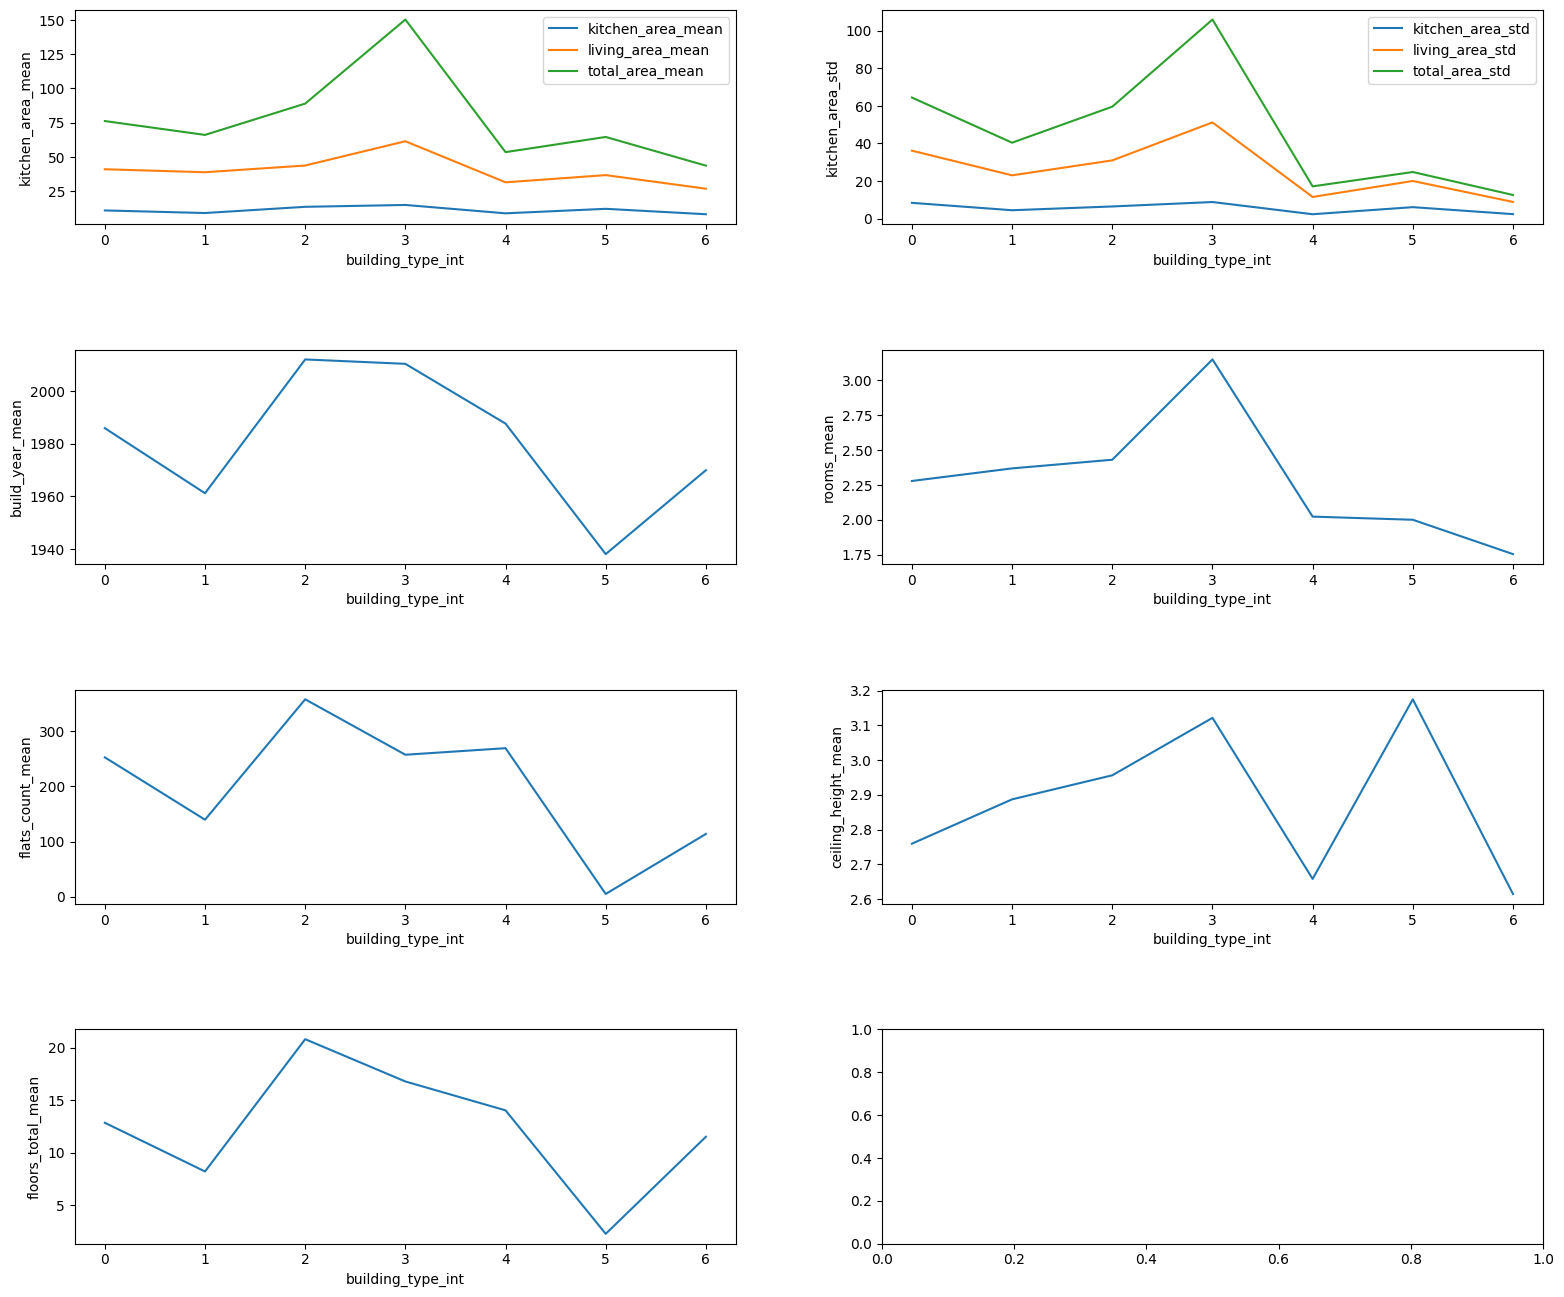

In [10]:

fig, axs = plt.subplots(4,2)
fig.tight_layout(pad=1)
fig.set_size_inches(16.5, 14 ,forward=True)

for col in [x for x in  building_type_agg.columns if 'area_mean' in x]:
    sns.lineplot(building_type_agg,x=x,y=col, ax=axs[0,0],label=col)

for col in [x for x in  building_type_agg.columns if 'area_std' in x]:
    sns.lineplot(building_type_agg,x=x,y=col, ax=axs[0,1],label=col)

sns.lineplot(building_type_agg,x=x,y='build_year_mean', ax=axs[1,0])

sns.lineplot(building_type_agg,x=x,y='rooms_mean', ax=axs[1,1])
sns.lineplot(building_type_agg,x=x,y='flats_count_mean', ax=axs[2,0])
sns.lineplot(building_type_agg,x=x,y='ceiling_height_mean', ax=axs[2,1])
sns.lineplot(building_type_agg,x=x,y='floors_total_mean', ax=axs[3,0])




# В целом, видно что каждый building_type характерен своими признаками. Можно предположить, что:
# building_type_int = 3 - частные дома с большой площадью
# building_type_int = 4 - относительно новые дома с низкими потолками и малой площадью. Вероятно квартиры-студии
# building_type_int = 5 - "сталинки" с высокими потолками и старой постройкой 

plt.savefig(os.path.join(ASSETS_DIR, 'building_type_int-numeric_columns'))


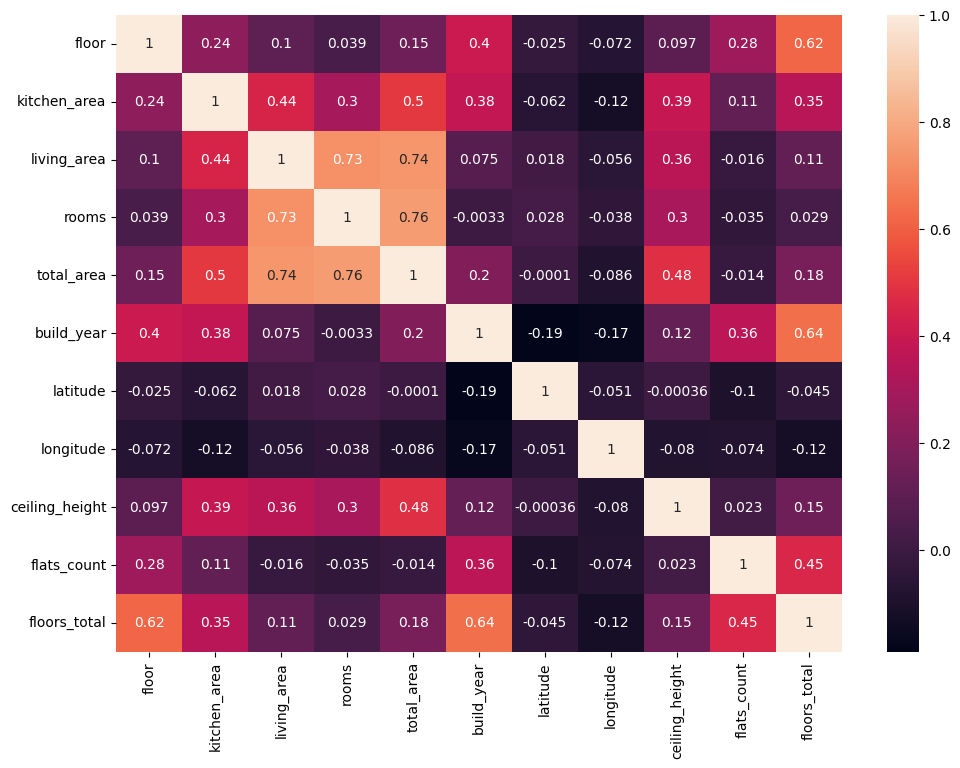

In [11]:
from matplotlib import rcParams
# figure size in inches
rcParams['figure.figsize'] = 11.7,8.27
feature_correlation = num_features.corr()
sns.heatmap(feature_correlation, annot=True)
plt.savefig(os.path.join(ASSETS_DIR, 'numeric_columns_correlation'))

# В целом, сильно коррелирующих признаков нет. Можно отметить лишь следующее:
# Достаточно сильная корреляция между количеством комнат, жилой и общей площадью (что логично). Вероятно стоит оставить только одну общую площадь
# Средняя корреляция между годом постройки и количеством этажей

In [12]:
floor_locality = re_df['floors_total']/re_df['floor']
floor_locality.describe()
# 

count    118808.000000
mean          3.070429
std           3.059160
min           1.000000
25%           1.272727
50%           1.857143
75%           3.500000
max          40.000000
dtype: float64

##### 2.4 Анализ целевой переменной

In [13]:
re_df['price']  = re_df['price'].astype('int')


In [14]:
re_df['price'].describe()

count    1.188080e+05
mean     1.931485e+07
std      6.990619e+07
min      1.100000e+01
25%      8.999999e+06
50%      1.190000e+07
75%      1.690000e+07
max      9.873738e+09
Name: price, dtype: float64

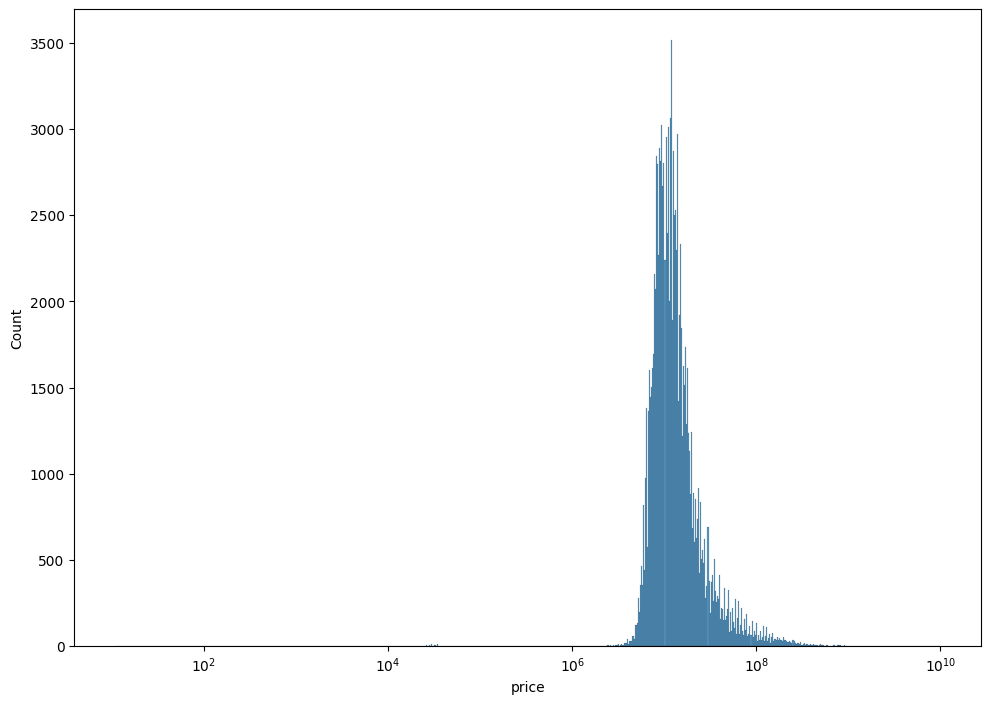

In [15]:
sns.histplot(data=re_df, x='price',log_scale=True)
plt.savefig(os.path.join(ASSETS_DIR, 'price_histogram'))

In [16]:
re_df.loc[re_df['price'] < 1000000]
# Странные цены на квартиры - то ли указаны в долларах, то ли это доля от квартиры, то ли что-то еще. Вероятно, будут влиять на качество. неплохо бы понять, имеется ли тут ошибка в цене.

,flat_id,floor,is_apartment,kitchen_area,living_area,rooms,total_area,building_id,build_year,building_type_int,latitude,longitude,ceiling_height,flats_count,floors_total,has_elevator,price
10105,1572,12,false,9.7,33.0,2,53.700001,21366,2009,4,55.651024,37.343372,2.64,180,17,true,11200
10693,10471,12,false,9.0,22.0,1,40.000000,14289,1985,4,55.625828,37.718166,2.64,223,17,true,30000
10746,10533,6,false,12.0,30.0,1,60.000000,16757,1997,4,55.535595,37.534191,2.64,152,6,true,33000
10785,10628,12,false,10.0,19.0,1,36.000000,22586,2014,2,55.431023,36.865036,2.80,204,17,true,16000
13165,15608,4,false,25.0,110.0,4,135.000000,950,1940,1,55.772644,37.591045,3.20,135,8,true,152000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114633,136930,8,false,9.0,30.0,2,50.000000,16092,1994,4,55.834518,37.450272,2.64,127,17,true,42000
114685,136983,5,false,13.0,34.0,2,60.000000,22519,2013,4,55.708416,37.928974,2.70,183,17,true,6800
114861,137162,4,false,9.0,20.0,1,40.000000,6439,1966,1,55.844582,37.491531,2.48,198,5,false,2400
114992,137296,8,false,9.0,32.0,2,54.000000,11602,1976,4,55.609745,37.516781,2.64,721,16,true,37000


##### 2.4 Анализ целевой переменной в зависимости от различных признаков

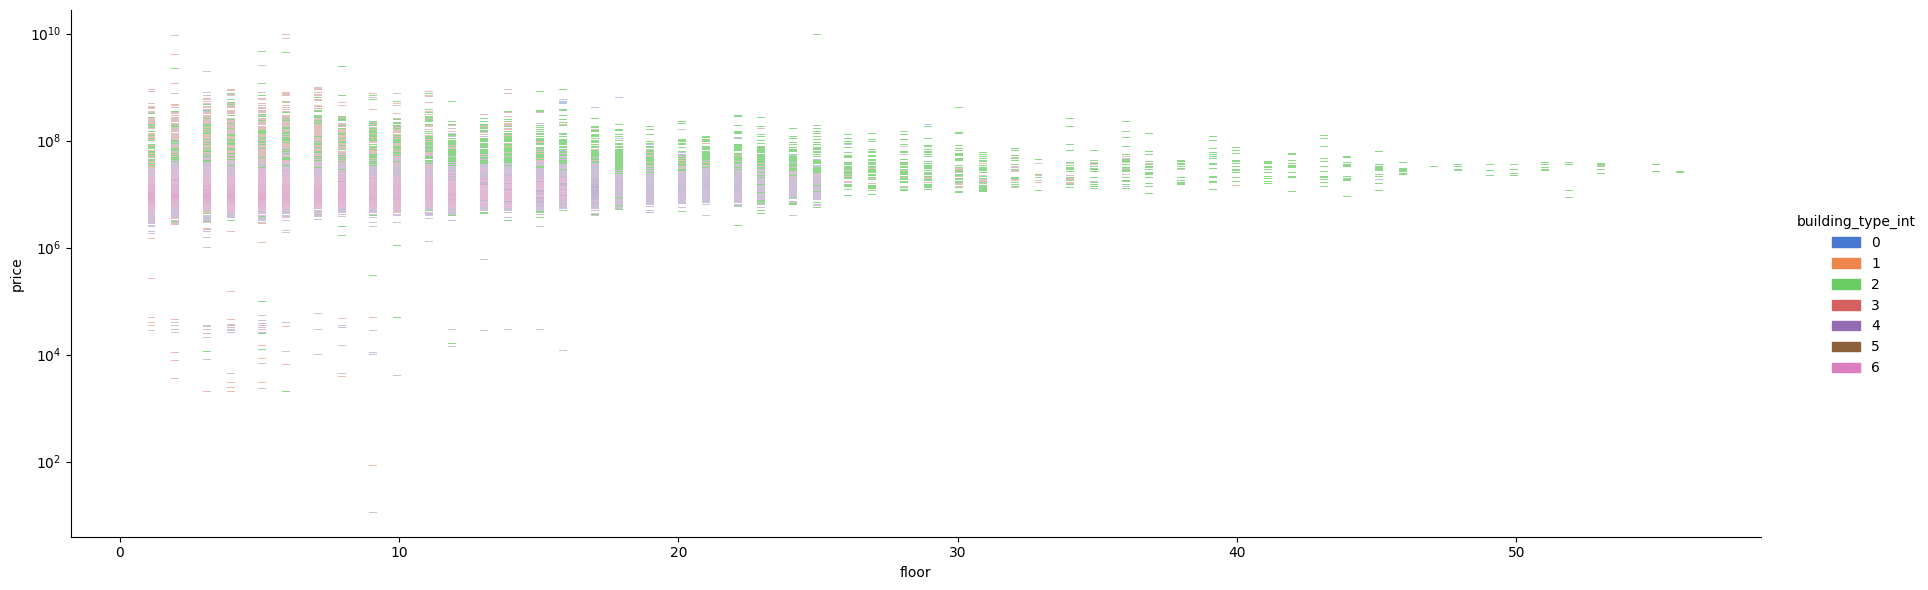

In [17]:
sns.displot(data=re_df, x ='floor', y='price', hue='building_type_int', height=6, aspect=3,log_scale=[False, True], palette='muted')
plt.savefig(os.path.join(ASSETS_DIR, 'price-floor'))
# Наблюдается кластер невысоких этажей с низкой ценой, котрый не связан с типом building_type_int

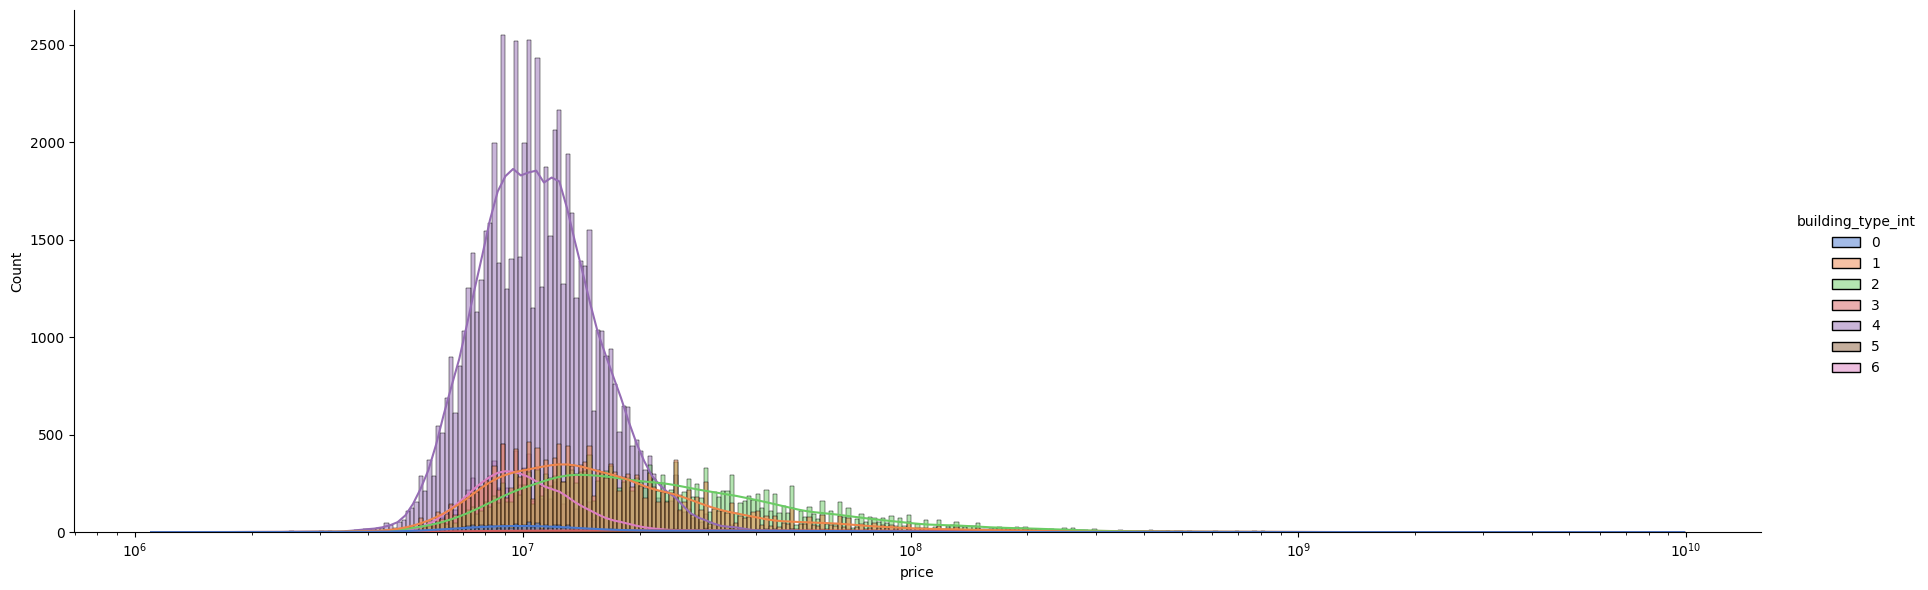

In [18]:
sns.displot(data=re_df.loc[re_df['price']>1000000], x ='price', hue='building_type_int',height=6, aspect=3, kde=True, log_scale=True,palette="muted")
plt.savefig(os.path.join(ASSETS_DIR, 'price-building_type_int'))
# Для разных групп разные распределения по цене

/tmp/ipykernel_971709/3889070763.py:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.displot(data=re_df.loc[re_df['price']>1000000], x ='price', y='floor', height=6, aspect=3, log_scale=[True, False],palette="muted")


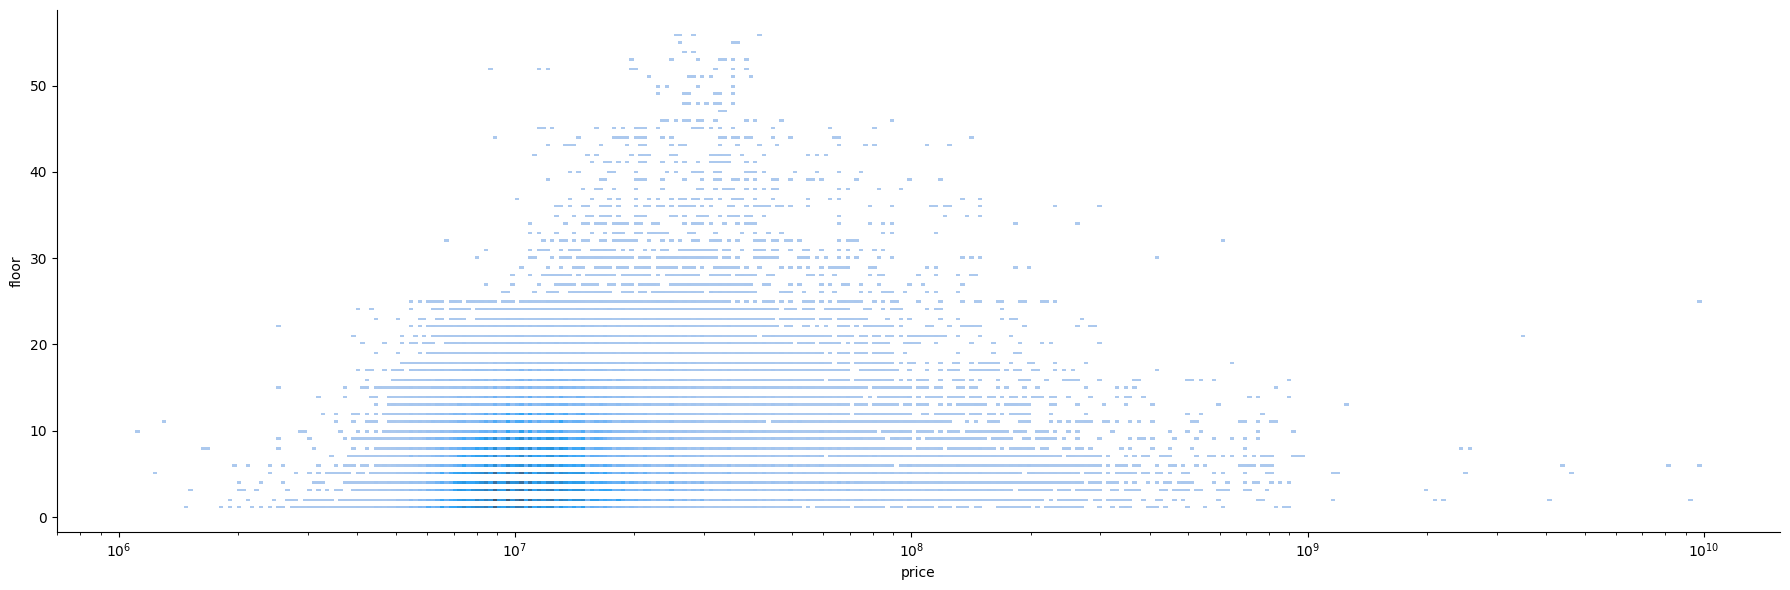

In [19]:
sns.displot(data=re_df.loc[re_df['price']>1000000], x ='price', y='floor', height=6, aspect=3, log_scale=[True, False],palette="muted")
plt.savefig(os.path.join(ASSETS_DIR, 'price-floor-2'))
# Сильной зависимости от этажа нет. Самые дорогие квартиры обычно ниже 10 этажа

/tmp/ipykernel_971709/2285426489.py:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.displot(data=re_df.loc[(re_df['price']>1000000) & (re_df['price']<100000000)], x ='price', y='total_area', height=6, aspect=3, log_scale=[True, False],palette="muted")


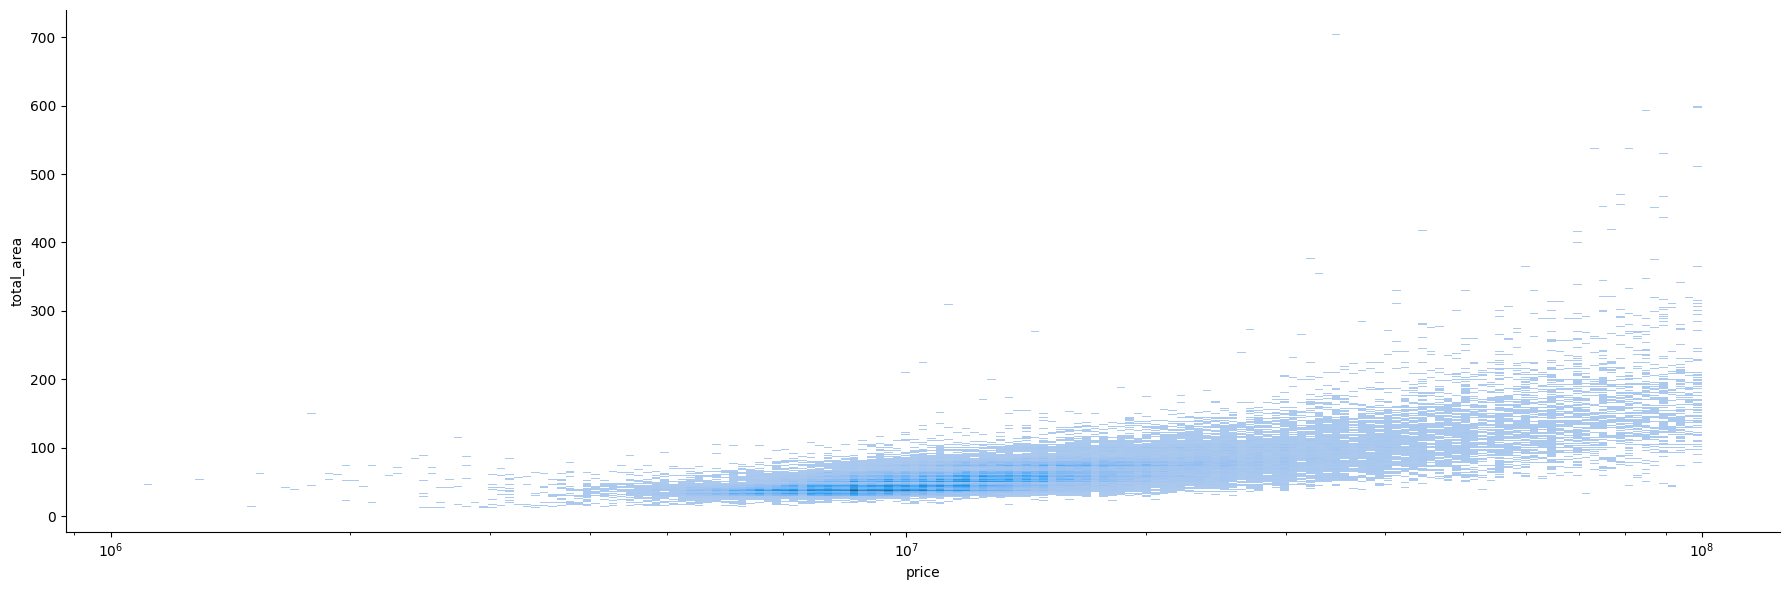

In [20]:
sns.displot(data=re_df.loc[(re_df['price']>1000000) & (re_df['price']<100000000)], x ='price', y='total_area', height=6, aspect=3, log_scale=[True, False],palette="muted")
plt.savefig(os.path.join(ASSETS_DIR, 'price-total_area'))
# При цене до 12 млн зависимости от площади квартиры практически нет. Дороже 12 млн - цена растет экспоненциально 

/tmp/ipykernel_971709/1620685074.py:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.displot(data=re_df.loc[(re_df['price']>1000000) & (re_df['price']<100000000)], x ='price', y=floor_locality, height=6, aspect=3, log_scale=[True, False],palette="muted")


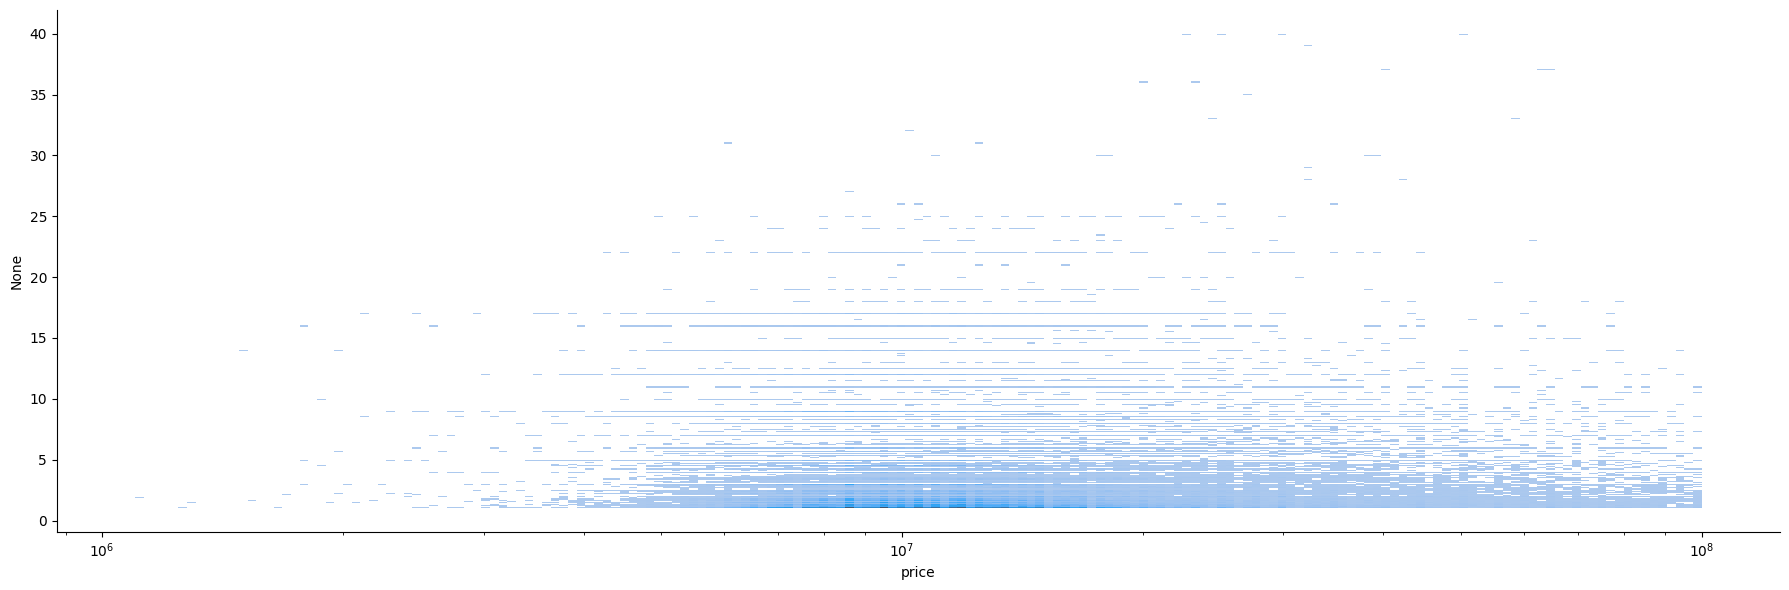

In [21]:
sns.displot(data=re_df.loc[(re_df['price']>1000000) & (re_df['price']<100000000)], x ='price', y=floor_locality, height=6, aspect=3, log_scale=[True, False],palette="muted")
# floor_locality - признак, показывающий относительное положение этажа в доме - внизу, в центре, наверху. Если равен 1 - последний этаж. Если равен  

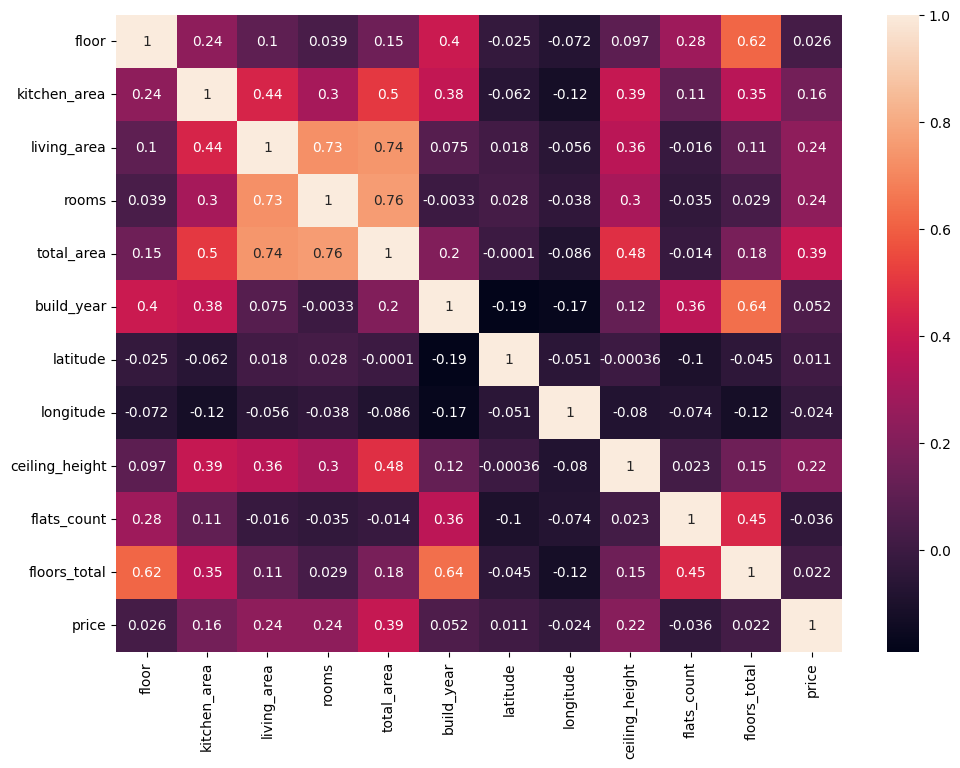

In [22]:
rcParams['figure.figsize'] = 11.7,8.27
feature_price_correlation = pd.concat([num_features, re_df['price']],axis=1).corr()
sns.heatmap(feature_price_correlation, annot=True)
plt.savefig(os.path.join(ASSETS_DIR, 'numeric_columns-price_correlation'))

# Нельзя сказать что есть набор признков, котороые сильно влияют на цену. Самая большая корреляция с ценой у площади и высоты потолков


##### 2.5 Выводы после EDA

1. В целом, видно что каждый building_type характерен своими признаками. Можно предположить, что:

    * building_type_int = 3 - частные дома с большой площадью

    * building_type_int = 4 - относительно новые дома с низкими потолками и малой площадью. Вероятно квартиры-студии

    * building_type_int = 5 - "сталинки" с высокими потолками и старой постройкой 


2. В целом, сильно коррелирующих признаков нет. Можно отметить лишь следующее:

    * Достаточно сильная корреляция между количеством комнат, жилой и общей площадью (что логично). Вероятно стоит оставить только одну общую площадь

    * Средняя корреляция между годом постройки и количеством этажей


3. Есть странные цены на квартиры - то ли указаны в долларах, то ли это доля от квартиры, то ли что-то еще. Вероятно, будут влиять на качество. неплохо бы понять, имеется ли тут ошибка в цене.


4. Наблюдается кластер невысоких этажей с низкой ценой, котрый не связан с типом ```building_type_int```


5. Для разных ```building_type_int``` разные распределения по цене


6. Сильной зависимости от этажа нет. Самые дорогие квартиры обычно ниже 10 этажа


7. При цене до 12 млн зависимости от площади квартиры практически нет. Дороже 12 млн - цена растет экспоненциально 

8. Имеет смысл выделить первый и последний этаж в отдельные переменные



##### 2.6 логирование артефактов в MLflow

In [23]:
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id
    mlflow.log_artifacts(ASSETS_DIR)
    mlflow.log_artifact('project_template_sprint_2.ipynb')

In [57]:
#mlflow.delete_run('74e831d49739487093119c29c16116ed')

#### Этап 3: Генерация Признаков и Обучение Новой Версии Модели
После тщательного исследовательского анализа данных (EDA), вы, скорее всего, сформировали несколько гипотез относительно новых признаков, которые могут улучшить качество вашей модели. На этом этапе, мы предлагаем вам приступить к генерации новых признаков и последующему обучению модели, используя два подхода:

Ручная генерация признаков: Используйте ваше понимание данных и результаты EDA для создания новых признаков.

Автоматическая генерация признаков: Воспользуйтесь библиотеками для автоматической генерации признаков, чтобы облегчить и ускорить этот процесс.

Важно: Для признаков, созданных вручную, рекомендуется использовать объекты sklearn, такие как Pipeline и ColumnTransformer. Это позволит автоматизировать процесс преобразования данных и облегчить поддержку вашего проекта.

После генерации новых признаков, наступает время обучить новую версию вашей модели, используя эти признаки. Не забудьте залогировать все результаты, включая новые признаки, параметры модели и метрики качества, в MLflow для удобства отслеживания изменений и результатов.

Рекомендуемые шаги:

- Определение и генерация новых признаков на основе ваших гипотез.
- Использование библиотек для автоматической генерации признаков, если это применимо.
- Интеграция новых признаков в вашу модель с помощью Pipeline или ColumnTransformer для ручно созданных признаков.
- Обучение новой версии модели с использованием всех доступных признаков.
- Логирование результатов в MLflow для документирования и анализа эффективности новых признаков и модели.

Этот этап проекта критически важен для повышения точности и эффективности вашей модели. Тщательная работа на этом этапе может существенно повлиять на итоговое качество моделирования.


##### 3.1 ручная генерация признаков

In [23]:
from sklearn.preprocessing import (
    OneHotEncoder, 
    SplineTransformer, 
    QuantileTransformer, 
    RobustScaler,
    PolynomialFeatures,
    KBinsDiscretizer,
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from category_encoders import CatBoostEncoder
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error

In [24]:
n_knots = 3
degree_spline = 4
spl_enc = SplineTransformer(n_knots=n_knots, degree=degree_spline)

In [25]:
n_quantiles = 25
q_enc = QuantileTransformer(n_quantiles=n_quantiles)

In [26]:
rb_enc = RobustScaler()

In [27]:
degree = 3
pol_enc = PolynomialFeatures(degree=degree)

In [28]:
n_bins = 5
encode = 'ordinal'
strategy = 'uniform'
subsample = None
kbd_enc = KBinsDiscretizer(n_bins=n_bins, encode=encode, strategy=strategy, subsample=subsample)

In [29]:
re_df['is_first_floor'] = re_df['floor'] == 1
re_df['is_last_floor'] = re_df['floor'] == re_df['floors_total'] 


##### 3.2 оборачивание всех преобразований в объекты sklearn

In [30]:
features = re_df.drop(columns=['flat_id','building_id', 'price'])
num_features = features.select_dtypes(include=['int64', 'float64']).drop(columns=['building_type_int'])
cat_features = features.select_dtypes(include=['object', 'bool'])
cat_features = pd.concat([cat_features, re_df['building_type_int']], axis=1)

num_features_columns = num_features.columns
cat_features_columns = cat_features.columns

In [31]:
numeric_transformer = ColumnTransformer(
    transformers=[
        ('spl', spl_enc, num_features_columns),
        ('q', q_enc, num_features_columns),
        ('rb', rb_enc, num_features_columns),
        ('pol', pol_enc, num_features_columns),
        ('kbd', kbd_enc, num_features_columns),
        ('scaler', StandardScaler(), num_features_columns),
    ]
)

cb_enc = CatBoostEncoder()

categorical_transformer = Pipeline(
    steps=[('cb_encoder', cb_enc)]
    
)




In [32]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features_columns),
        ('cat', categorical_transformer, cat_features_columns),
    ],
    n_jobs=-1,
    remainder='drop',
    verbose_feature_names_out=False
)

In [33]:
X_train, X_test, y_train, y_test = train_test_split(re_df.drop(columns='price'), re_df['price'], test_size=0.3, random_state=3)


In [34]:

model = CatBoostRegressor() 

pipeline = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('model', model)
    ]
)


pipeline.fit(X_train, y_train)
prediction = pipeline.predict(X_test)

metrics = {}
mae = mean_absolute_error(y_test, prediction).round(2)
mse = mean_squared_error(y_test, prediction).round(2)
mape = mean_absolute_percentage_error(y_test, prediction).round(2)
metrics["mae"] = mae
metrics["mse"] = mse
metrics["mape"] = mape


Learning rate set to 0.082325
0:	learn: 77649928.8825006	total: 88.5ms	remaining: 1m 28s
1:	learn: 76797973.4808666	total: 131ms	remaining: 1m 5s
2:	learn: 76063369.9937805	total: 174ms	remaining: 57.8s
3:	learn: 75222586.9546713	total: 217ms	remaining: 54.1s
4:	learn: 74649575.1923849	total: 257ms	remaining: 51.2s
5:	learn: 74158515.7953096	total: 296ms	remaining: 49.1s
6:	learn: 73697434.7148896	total: 338ms	remaining: 47.9s
7:	learn: 73235247.7256308	total: 379ms	remaining: 47s
8:	learn: 72858644.9530160	total: 423ms	remaining: 46.6s
9:	learn: 72556352.4790277	total: 468ms	remaining: 46.3s
10:	learn: 72082433.7271815	total: 508ms	remaining: 45.7s
11:	learn: 71585928.4597386	total: 548ms	remaining: 45.1s
12:	learn: 71369881.8654210	total: 587ms	remaining: 44.6s
13:	learn: 71145965.0651882	total: 631ms	remaining: 44.4s
14:	learn: 70814817.7171131	total: 674ms	remaining: 44.3s
15:	learn: 70532768.8038263	total: 723ms	remaining: 44.4s
16:	learn: 70377445.3415395	total: 768ms	remaining: 

In [141]:

pip_requirements = "../requirements.txt"
metadata =  {'model_type': 'estate_regression'}
signature = mlflow.models.infer_signature(X_test, prediction)
input_example = X_train[:10]

RUN_NAME = 'feature_transforming'
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    # получаем уникальный идентификатор запуска эксперимента
    run_id = run.info.run_id 
    
    model_info = mlflow.sklearn.log_model( 
			sk_model=model,
            pip_requirements=pip_requirements,
            metadata=metadata,
            await_registration_for=60,
            input_example=input_example,
            signature=signature,
            artifact_path="models",
            registered_model_name=REGISTRY_MODEL_NAME)

    mlflow.log_metrics(metrics) 

run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

/home/andrey/work/MLE/mle-project-sprint-2-v001/.venv_sprint02/lib/python3.10/site-packages/mlflow/models/signature.py:212: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input) if model_input is not None else None
Registered model 'estate_model' already exists. Creating a new version of this model...
2024/04/17 14:11:39 INFO mlflow.tracking._mod

#### 3.3 автоматическая генерация признаков

In [35]:
from autofeat import AutoFeatRegressor

In [36]:
afreg = AutoFeatRegressor(verbose=1, feateng_steps=2, max_gb=16, transformations=[ "sqrt", "1/", "log","exp","exp-","^2"] )

In [48]:
features_af = afreg.fit_transform(X_train[num_features_columns], y_train)
features_af

2024-04-17 14:54:05,878 INFO: [AutoFeat] The 2 step feature engineering process could generate up to 2211 features.
2024-04-17 14:54:05,879 INFO: [AutoFeat] With 83165 data points this new feature matrix would use about 0.74 gb of space.
2024-04-17 14:54:05,885 INFO: [feateng] Step 1: transformation of original features


2024-04-17 14:54:07,851 INFO: [feateng] Generated 51 transformed features from 11 original features - done.
2024-04-17 14:54:07,865 INFO: [feateng] Step 2: first combination of features


2024-04-17 14:54:12,204 INFO: [feateng] Generated 1865 feature combinations from 1891 original feature tuples - done.
2024-04-17 14:54:12,794 INFO: [feateng] Generated altogether 1927 new features in 2 steps
2024-04-17 14:54:12,795 INFO: [feateng] Removing correlated features, as well as additions at the highest level
2024-04-17 14:54:14,168 INFO: [feateng] Generated a total of 704 additional features


[featsel] Scaling data...

2024-04-17 14:54:14,911 INFO: [featsel] Feature selection run 1/5


done.


2024-04-17 14:54:39,440 INFO: [featsel] Feature selection run 2/5
2024-04-17 14:54:58,794 INFO: [featsel] Feature selection run 3/5
2024-04-17 14:55:21,035 INFO: [featsel] Feature selection run 4/5
2024-04-17 14:55:41,703 INFO: [featsel] Feature selection run 5/5
2024-04-17 14:55:59,447 INFO: [featsel] 83 features after 5 feature selection runs
2024-04-17 14:56:00,449 INFO: [featsel] 73 features after correlation filtering
2024-04-17 14:56:03,177 INFO: [featsel] 53 features after noise filtering
2024-04-17 14:56:03,179 INFO: [AutoFeat] Computing 51 new features.


2024-04-17 14:56:11,399 INFO: [AutoFeat]    51/   51 new features ...done.
2024-04-17 14:56:11,437 INFO: [AutoFeat] Final dataframe with 62 feature columns (51 new).
2024-04-17 14:56:11,438 INFO: [AutoFeat] Training final regression model.
2024-04-17 14:56:12,373 INFO: [AutoFeat] Trained model: largest coefficients:
2024-04-17 14:56:12,373 INFO: -119928255.50982913
2024-04-17 14:56:12,374 INFO: -996931725.854175 * exp(-floors_total)*log(rooms)
2024-04-17 14:56:12,374 INFO: 518911675.134778 * sqrt(rooms)*exp(-ceiling_height)
2024-04-17 14:56:12,375 INFO: 495888459.740046 * rooms**2*exp(-floors_total)
2024-04-17 14:56:12,375 INFO: 122613014.198467 * exp(-ceiling_height)*log(living_area)
2024-04-17 14:56:12,375 INFO: -73925431.674643 * living_area*exp(-floors_total)
2024-04-17 14:56:12,376 INFO: -39325127.126982 * floors_total**2*exp(-floors_total)
2024-04-17 14:56:12,376 INFO: 37755947.069776 * exp(-flats_count)*log(rooms)
2024-04-17 14:56:12,376 INFO: -32537365.577970 * total_area*exp(-

,floor,kitchen_area,living_area,rooms,total_area,build_year,latitude,longitude,ceiling_height,flats_count,...,rooms/total_area,rooms**2*exp(-rooms),rooms**2*exp(-floor),total_area**2/living_area,exp(-flats_count)*log(rooms),log(flats_count)/floors_total,sqrt(total_area)/floors_total,total_area**2*exp(-living_area),exp(ceiling_height)/flats_count,exp(-floors_total)*log(flats_count)
0,10.0,8.946669,19.299999,1.0,34.700001,1985.0,55.668797,37.744682,2.48,111.0,...,0.028818,0.367879,4.539993e-05,62.388088,0.000000e+00,0.294346,0.368167,4.997765e-06,0.107579,5.299878e-07
1,15.0,8.946669,18.000000,1.0,42.000000,2015.0,55.930069,37.540157,2.70,352.0,...,0.023810,0.367879,3.059023e-07,98.000000,0.000000e+00,0.344919,0.381220,2.686568e-05,0.042272,2.427507e-07
2,3.0,6.000000,29.000000,2.0,43.000000,1959.0,55.733849,37.485100,2.48,80.0,...,0.046512,0.541341,1.991483e-01,63.758621,1.251028e-35,0.876405,1.311488,4.703238e-10,0.149266,2.952586e-02
3,5.0,9.000000,30.874632,2.0,52.000000,1988.0,55.639236,37.360294,2.70,166.0,...,0.038462,0.541341,2.695179e-02,87.579991,5.596822e-73,0.365142,0.515079,1.055175e-10,0.089637,4.250765e-06
4,6.0,8.000000,36.000000,2.0,56.000000,1955.0,55.725407,37.528362,3.00,66.0,...,0.035714,0.541341,9.915009e-03,87.111111,1.504491e-29,0.523707,0.935414,7.274024e-13,0.304326,1.405473e-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83160,4.0,6.500000,30.000000,2.0,45.000000,1967.0,55.705578,37.810520,2.64,100.0,...,0.044444,0.541341,7.326256e-02,67.500000,2.578560e-44,0.921034,1.341641,1.894919e-10,0.140132,3.102939e-02
83161,4.0,8.000000,20.000000,1.0,38.000000,1998.0,55.680546,37.574390,2.64,316.0,...,0.026316,0.367879,1.831564e-02,72.200000,0.000000e+00,0.411124,0.440315,2.976306e-06,0.044346,4.786065e-06
83162,5.0,5.600000,25.600000,2.0,40.799999,1962.0,55.777935,37.556992,2.60,58.0,...,0.049020,0.541341,2.695179e-02,65.024997,4.484825e-26,0.812089,1.277498,1.268766e-08,0.232133,2.735905e-02
83163,8.0,8.946669,30.874632,2.0,80.000000,2008.0,55.663673,37.486732,3.00,667.0,...,0.025000,0.541341,1.341851e-03,207.289921,1.466919e-290,0.197054,0.271039,2.497455e-10,0.030113,3.029576e-14


In [49]:
with open(ASSETS_DIR+'/autofeat_columns.txt', 'w') as f:
    for line in features_af.columns:
        f.write(f"{line}\n")

In [50]:
preprocessor_w_af = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features_columns),
        ('af', afreg, num_features_columns),
        ('cat', categorical_transformer, cat_features_columns),
    ],
    n_jobs=-1,
    remainder='drop',
    verbose_feature_names_out=False
)

#### 3.4 обучение новой версии модели 
#### 3.5 логирование артефактов в MLflow 

In [51]:

model = CatBoostRegressor() 

pipeline = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('model', model)
    ]
)


pipeline.fit(X_train, y_train)
prediction = pipeline.predict(X_test)

metrics = {}
mae = mean_absolute_error(y_test, prediction).round(2)
mse = mean_squared_error(y_test, prediction).round(2)
mape = mean_absolute_percentage_error(y_test, prediction).round(2)
metrics["mae"] = mae
metrics["mse"] = mse
metrics["mape"] = mape


Learning rate set to 0.082325
0:	learn: 77649928.8825006	total: 49.3ms	remaining: 49.3s
1:	learn: 76797973.4808666	total: 97.9ms	remaining: 48.8s
2:	learn: 76063369.9937805	total: 144ms	remaining: 47.9s
3:	learn: 75222586.9546713	total: 195ms	remaining: 48.6s
4:	learn: 74649575.1923849	total: 253ms	remaining: 50.3s
5:	learn: 74158515.7953096	total: 324ms	remaining: 53.6s
6:	learn: 73697434.7148896	total: 383ms	remaining: 54.4s
7:	learn: 73235247.7256308	total: 435ms	remaining: 53.9s
8:	learn: 72858644.9530160	total: 481ms	remaining: 53s
9:	learn: 72556352.4790277	total: 528ms	remaining: 52.3s
10:	learn: 72082433.7271815	total: 571ms	remaining: 51.3s
11:	learn: 71585928.4597386	total: 617ms	remaining: 50.8s
12:	learn: 71369881.8654210	total: 658ms	remaining: 50s
13:	learn: 71145965.0651882	total: 703ms	remaining: 49.5s
14:	learn: 70814817.7171131	total: 745ms	remaining: 48.9s
15:	learn: 70532768.8038263	total: 788ms	remaining: 48.5s
16:	learn: 70377445.3415395	total: 832ms	remaining: 48

In [54]:

pip_requirements = "../requirements.txt"
metadata =  {'model_type': 'estate_regression'}
signature = mlflow.models.infer_signature(X_test, prediction)
input_example = X_train[:10]

RUN_NAME = 'feature_transforming_w_af'
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    # получаем уникальный идентификатор запуска эксперимента
    run_id = run.info.run_id 
    
    model_info = mlflow.sklearn.log_model( 
			sk_model=pipeline,
            pip_requirements=pip_requirements,
            metadata=metadata,
            await_registration_for=60,
            input_example=input_example,
            signature=signature,
            artifact_path="models",
            registered_model_name=REGISTRY_MODEL_NAME)
    mlflow.log_artifact(ASSETS_DIR+'/autofeat_columns.txt')
    mlflow.log_metrics(metrics) 
run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

/home/andrey/work/MLE/mle-project-sprint-2-v001/.venv_sprint02/lib/python3.10/site-packages/mlflow/models/signature.py:212: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input) if model_input is not None else None
Registered model 'estate_model' already exists. Creating a new version of this model...
2024/04/17 14:59:01 INFO mlflow.tracking._mod

#### Этап 4: Отбор Признаков и Обучение Новой Версии Модели
Создание новых признаков — это лишь часть работы. Следующий важный шаг — это убедиться в том, что каждый из этих признаков действительно вносит положительный вклад в качество модели. Некоторые признаки могут оказывать отрицательное влияние на модель, поэтому их следует исключить из анализа.

На этом этапе, мы рекомендуем вам применить различные методы отбора признаков для того, чтобы определить и удалить те признаки, которые не улучшают качество вашей модели. Цель этого этапа — максимизировать производительность модели, удалив избыточные или неинформативные признаки.

После тщательного отбора признаков, пора обучить новую версию вашей модели, уже без негативно влияющих на неё признаков. Важно залогировать результаты этого этапа, включая измененный набор признаков, параметры модели и полученные метрики качества, в MLflow для последующего анализа и сравнения.

Рекомендуемые шаги:

- Применение методов отбора признаков для идентификации и исключения признаков, ухудшающих качество модели.
- Анализ влияния каждого признака на модель, чтобы понять, какие из них наиболее ценные.
- Обучение новой версии модели без негативно влияющих признаков.
- Логирование всех изменений и результатов в MLflow, включая конечный набор признаков, параметры модели и метрики качества.

Этот этап не только поможет улучшить качество вашей модели, но и даст глубокое понимание о важности и влиянии отдельных признаков на результаты моделирования.


In [37]:
# 4.1 Отбор признаков при помощи метода номер 1

In [38]:
# 4.2 Отбор признаков при помощи метода номер 2

In [39]:
# 4.3 Анализ отобранных признаков при помощи двух методов и формирование финального списка с признаками для модели

In [40]:
# 4.4 Обучение новой версии модели

In [41]:
# 4.5 Логирование всех артефактов в MLflow

### Этап 5 - подбор гиперпараметров и обучение новой версии модели
После того как мы уделили значительное внимание качеству модели через создание и отбор признаков, пришло время для финального штриха — подбора гиперпараметров. Этот этап является ключевым в финальной части проекта второго спринта, где ваша задача — оптимизировать гиперпараметры модели для достижения наилучшего качества.

Рекомендуется подобрать гиперпараметры как минимум двумя различными методами (например, с использованием Grid Search и Random Search), чтобы вы могли сравнить результаты и выбрать наиболее эффективный набор гиперпараметров для вашей модели. После определения оптимальных гиперпараметров, наступает время обучить финальную версию модели, используя ваши новые признаки.

Рекомендуемые шаги:

- Выбор методов для подбора гиперпараметров: Определитесь с методами, которые вы будете использовать для подбора гиперпараметров (например, Grid Search, Random Search, Bayesian Optimization).
- Подбор гиперпараметров: Примените выбранные методы для нахождения оптимальных значений гиперпараметров вашей модели.
- Сравнение результатов: Анализируйте и сравнивайте результаты, полученные различными методами, для определения наилучшего набора гиперпараметров.
- Обучение финальной модели: Используя выбранные гиперпараметры, обучите финальную версию вашей модели на новых признаках.
- Документирование процесса и результатов: Залогируйте все шаги и результаты в MLflow, включая сравнение методов подбора гиперпараметров и характеристики финальной модели.

Этот этап позволит вам максимально улучшить качество вашей модели перед финальной оценкой, предоставив полное понимание важности и влияния гиперпараметров на производительность модели.

In [42]:
# 5.1 Подбор гиперпарметров при мощи метода номер 1

In [43]:
# 5.2 Подбор гиперпарметров при мощи метода номер 2

In [44]:
# 5.3 Формирование списка гиперпараметров для новой модели

In [45]:
# 5.4 Обуение финальной версии модели

In [46]:
# 5.5 Логирование артефактов в MLflow